### This example is almost equivalent to 05.Federated_Training_Inference. The differences are: i) preprocessing is performed using a global maximum and minimum, ii)  we perform predictions on a testing set and iii) we save the model to a .h5 format

In [59]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [60]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch
import pandas as pd

from matplotlib import pyplot as plt

from argparse import Namespace

In [61]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [62]:
from ml.utils.train_utils import train, test

In [63]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [64]:
from ml.fl.defaults import create_regression_client
from ml.fl.client_proxy import SimpleClientProxy
from ml.fl.server.server import Server
from ml.utils.helpers import accumulate_metric

In [65]:
args = Namespace(
    data_path='../dataset/full_dataset.csv', # dataset

    test_size=0.2, # validation size 
    targets=['temp','pH','DissolvedOxygen','Conductivity','Turbidity','AmmoniaNitrogen'], # the target columns    num_lags=10, # the number of past observations to feed as input
    num_lags=10, # the number of past observations to feed as input

    identifier='District', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=True, # whether to perform flooring and capping

    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=30, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fedavg", # federated aggregation algorithm
    epochs=3, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [66]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(aggregation='fedavg', assign_stats=None, batch_size=128, criterion='mse', cuda=True, data_path='../dataset/full_dataset.csv', epochs=3, fl_rounds=30, fraction=1.0, identifier='District', local_early_stopping=False, local_patience=50, lr=0.001, max_grad_norm=0.0, nan_constant=0, num_lags=10, optimizer='adam', outlier_detection=True, reg1=0.0, reg2=0.0, seed=0, targets=['temp', 'pH', 'DissolvedOxygen', 'Conductivity', 'Turbidity', 'AmmoniaNitrogen'], test_size=0.2, use_time_features=False, x_scaler='minmax', y_scaler='minmax')



In [67]:
device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [68]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['Conductivity', 'Turbidity', 'pH', 'DissolvedOxygen']
    outlier_kwargs = {"upstream": (10, 90), "midstream": (10, 90), "downstream": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [69]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [70]:
seed_all()

In [71]:
def make_preprocessing():
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets)
    
    # scale X
    X_train, X_val, x_scaler = scale_features(train_data=X_train, val_data=X_val,
                                              scaler=args.x_scaler,
                                              per_area=False,
                                              identifier=args.identifier)
    # scale y
    y_train, y_val, y_scaler = scale_features(train_data=y_train, val_data=y_val,
                                              scaler=args.y_scaler, 
                                              per_area=False,
                                              identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None
        
    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler

In [72]:
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler = make_preprocessing()

INFO logger 2024-06-03 11:04:57,523 | data_utils.py:383 | Observations info in upstream
INFO logger 2024-06-03 11:04:57,524 | data_utils.py:384 | 	Total number of samples:  4863
INFO logger 2024-06-03 11:04:57,524 | data_utils.py:385 | 	Number of samples for training: 3891
INFO logger 2024-06-03 11:04:57,524 | data_utils.py:386 | 	Number of samples for validation:  972
INFO logger 2024-06-03 11:04:57,527 | data_utils.py:383 | Observations info in midstream
INFO logger 2024-06-03 11:04:57,528 | data_utils.py:384 | 	Total number of samples:  4930
INFO logger 2024-06-03 11:04:57,528 | data_utils.py:385 | 	Number of samples for training: 3944
INFO logger 2024-06-03 11:04:57,529 | data_utils.py:386 | 	Number of samples for validation:  986
INFO logger 2024-06-03 11:04:57,531 | data_utils.py:383 | Observations info in downstream
INFO logger 2024-06-03 11:04:57,532 | data_utils.py:384 | 	Total number of samples:  4920
INFO logger 2024-06-03 11:04:57,533 | data_utils.py:385 | 	Number of sample

In [73]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    if exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [74]:
X_train, X_val, y_train, y_val, client_X_train, client_X_val, client_y_train, client_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler)

In [75]:
for client in client_X_train:
    print(f"\nClient: {client}")
    print(f"X_train shape: {client_X_train[client].shape}, y_train shape: {client_y_train[client].shape}")
    print(f"X_val shape: {client_X_val[client].shape}, y_val shape: {client_y_val[client].shape}")


Client: upstream
X_train shape: (3881, 10, 9, 1), y_train shape: (3881, 6)
X_val shape: (962, 10, 9, 1), y_val shape: (962, 6)

Client: midstream
X_train shape: (3934, 10, 9, 1), y_train shape: (3934, 6)
X_val shape: (976, 10, 9, 1), y_val shape: (976, 6)

Client: downstream
X_train shape: (3926, 10, 9, 1), y_train shape: (3926, 6)
X_val shape: (974, 10, 9, 1), y_val shape: (974, 6)


In [76]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [77]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [78]:
# define the model
args.model_name = "lstm"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=y_train.shape[1],
                  lags=args.num_lags,
                  exogenous_dim=exogenous_dim,
                  seed=args.seed)

9 0


In [79]:
model

LSTM(
  (lstm): LSTM(9, 128, batch_first=True)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=True)
  )
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [80]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=[0,1,3,7,8,2], # the indices of our targets in X
        log_per=1,
        client_creation_fn = None, # client specification
        local_train_params=None, # local params
        aggregation_params=None, # aggregation params
        use_carbontracker=False
       ):
    # client creation definition
    if client_creation_fn is None:
        client_creation_fn = create_regression_client
    # local params
    if local_train_params is None:
        local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device
        }
    
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = tmp_exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                X_train[client], y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                X_val[client], y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
            
        )
        
    # create clients with their local data
    cids = [k for k in X_train.keys() if k != "all"]
    clients = [
        client_creation_fn(
            cid=cid, # client id
            model=model, # the global model
            train_loader=train_loader, # the local train loader
            test_loader=val_loader, # the local val loader
            local_params=local_train_params # local parameters
        )
        for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders)
    ]
    
    # represent clients to server
    client_proxies = [
        SimpleClientProxy(cid, client) for cid, client in zip(cids, clients)
    ]
    
    # represent the server
    server = Server(
        client_proxies=client_proxies, # the client representations
        aggregation=args.aggregation, # the aggregation algorithm
        aggregation_params=aggregation_params, # aggregation specific params
        local_params_fn=None, # we can change the local params on demand
    )
    # Note that the client manager instance will be initialized automatically. You can define your own client manager.

    # train with FL
    model_params, history = server.fit(args.fl_rounds, args.fraction, use_carbontracker=use_carbontracker)
    
    params_dict = zip(model.state_dict().keys(), model_params)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model = copy.deepcopy(model)
    model.load_state_dict(state_dict, strict=True)
    
    return model, history

In [81]:
# federated local params
local_train_params = {"epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
                      "criterion": args.criterion, "early_stopping": args.local_early_stopping,
                      "patience": args.local_patience, "device": device
                      }

In [82]:
global_model, history = fit(
    model,
    client_X_train,
    client_y_train, 
    client_X_val, 
    client_y_val, 
    local_train_params=local_train_params
)

INFO logger 2024-06-03 11:04:58,258 | server.py:62 | Initializing client manager...
INFO logger 2024-06-03 11:04:58,259 | server.py:69 | Registering clients...
INFO logger 2024-06-03 11:04:58,259 | client_manager.py:66 | Registered client with id: upstream
INFO logger 2024-06-03 11:04:58,259 | client_manager.py:66 | Registered client with id: midstream
INFO logger 2024-06-03 11:04:58,261 | client_manager.py:66 | Registered client with id: downstream
INFO logger 2024-06-03 11:04:58,261 | server.py:73 | Client manager initialized!
INFO logger 2024-06-03 11:04:58,261 | server.py:55 | Aggregation algorithm: FedAvg()
INFO logger 2024-06-03 11:04:58,262 | client_manager.py:88 | Parameter c=0.0. Sampled 1 client(s): ['midstream']
INFO logger 2024-06-03 11:04:59,364 | server.py:86 | Starting FL rounds
INFO logger 2024-06-03 11:04:59,364 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['midstream', 'upstream', 'downstream']
INFO logger 2024-06-03 11:05:00,120 | train_utils.py:142

In [83]:
def transform_preds(y_pred_train, y_pred_val):
    if not isinstance(y_pred_train, np.ndarray):
        y_pred_train = y_pred_train.cpu().numpy()
    if not isinstance(y_pred_val, np.ndarray):
        y_pred_val = y_pred_val.cpu().numpy()
    return y_pred_train, y_pred_val

def round_predictions(y_pred_train, y_pred_val, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_train, y_pred_val
    for dim in dims:
        y_pred_train[:, dim] = np.rint(y_pred_train[:, dim])
        y_pred_val[:, dim] = np.rint(y_pred_val[:, dim])
    return y_pred_train, y_pred_val

def inverse_transform(y_train, y_val, y_pred_train, y_pred_val,
                     y_scaler=None, 
                     round_preds=False, dims=None):
    y_pred_train, y_pred_val = transform_preds(y_pred_train, y_pred_val)
    
    if y_scaler is not None:
        y_train = y_scaler.inverse_transform(y_train)
        y_val = y_scaler.inverse_transform(y_val)
        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_val = y_scaler.inverse_transform(y_pred_val)
    
    # to zeroes
    y_pred_train[y_pred_train < 0.] = 0.
    y_pred_val[y_pred_val < 0.] = 0.
    
    if round_preds:
        y_pred_train, y_pred_val = round_predictions(y_pred_train, y_pred_val, dims)
    
    return y_train, y_val, y_pred_train, y_pred_val

In [84]:
def make_plot(y_true, y_pred, 
              title, 
              feature_names=None, 
              client=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(8, 6))
        plt.ticklabel_format(style='plain')
        plt.plot(y_true[:, i], label="Actual")
        plt.plot(y_pred[:, i], label="Predicted")
        if client is not None:
            plt.title(f"[{client} {title}] {feature_names[i]} prediction")
        else:
            plt.title(f"[{title}] {feature_names[i]} prediction")
        plt.legend()
        plt.show()
        plt.close()

In [85]:
def inference(
    model, # the global model
    client_X_train, # train data per client
    client_y_train,
    client_X_val, # val data per client
    client_y_val,
    exogenous_data_train, # exogenous data per client
    exogenous_data_val,
    y_scaler, # the scaler used to transform the targets
    idxs=[0,1,3,7,8,2], # the indices of our targets in X
    apply_round=True, # round to closest integer
    round_dimensions=[0, 3, 4], # the dimensions to apply rounding
    plot=True, # plot predictions
):
    # load per client data to torch
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in client_X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(client_X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                client_X_train[client], client_y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                client_X_val[client], client_y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
            
        )
        
    # get client ids
    cids = [k for k in client_X_train.keys() if k != "all"]
        
    # predict per client using the global model
    y_preds_train, y_preds_val = dict(), dict()
    for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders):
        print(f"Prediction on {cid}")
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, y_pred_train = test(
            model, train_loader, None, device=device
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, y_pred_val = test(
            model, val_loader, None, device=device
        )
        y_preds_train[cid] = y_pred_train
        y_preds_val[cid] = y_pred_val
    
    for cid in cids:
        y_train, y_val = client_y_train[cid], client_y_val[cid]
        y_pred_train, y_pred_val = y_preds_train[cid], y_preds_val[cid]
        
        y_train, y_val, y_pred_train, y_pred_val = inverse_transform(
            y_train, y_val, y_pred_train, y_pred_val,
            y_scaler, round_preds=apply_round, dims=round_dimensions
        )
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, train_res_per_dim = accumulate_metric(
            y_train, y_pred_train, True, return_all=True
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, val_res_per_dim = accumulate_metric(
            y_val, y_pred_val, True, return_all=True
        )
        
        print(f"\nFinal Prediction on {cid} (Inference Stage)")
        print(f"[Train]: mse: {train_mse}, "
              f"rmse: {train_rmse}, mae {train_mae}, r2: {train_r2}, nrmse: {train_nrmse}")
        print(f"[Val]: mse: {val_mse}, "
              f"rmse: {val_rmse}, mae {val_mae}, r2: {val_r2}, nrmse: {val_nrmse}\n\n")
        
        if plot:
            make_plot(y_train, y_pred_train, title="Train", feature_names=args.targets, client=cid)
            make_plot(y_val, y_pred_val, title="Val", feature_names=args.targets, client=cid)

Prediction on upstream
Prediction on midstream
Prediction on downstream


INFO logger 2024-06-03 11:06:18,420 | helpers.py:60 | Metrics for dimension: 0
	mse: 1.9128928184509277, rmse: 1.3830736851125929, mae: 1.0127286911010742, r^2: 0.9296955350724496, nrmse: 0.052833421523008586
INFO logger 2024-06-03 11:06:18,422 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.11082453280687332, rmse: 0.33290318833990357, mae: 0.24079468846321106, r^2: 0.8467966584600489, nrmse: 0.04410013851529415
INFO logger 2024-06-03 11:06:18,424 | helpers.py:60 | Metrics for dimension: 2
	mse: 0.5743359327316284, rmse: 0.7578495449174779, mae: 0.5512875914573669, r^2: 0.7573128866374523, nrmse: 0.10235068467996583
INFO logger 2024-06-03 11:06:18,425 | helpers.py:60 | Metrics for dimension: 3
	mse: 33612.515625, rmse: 183.33716378574204, mae: 140.24365234375, r^2: -51.434103603743345, nrmse: 1.1408386004354005
INFO logger 2024-06-03 11:06:18,427 | helpers.py:60 | Metrics for dimension: 4
	mse: 5.0903825759887695, rmse: 2.2561876198553987, mae: 1.5295747518539429, r^2: 0.8917232735


Final Prediction on upstream (Inference Stage)
[Train]: mse: 5603.37109375, rmse: 74.85566841428911, mae 23.938692092895508, r2: -7.863774664723613, nrmse: 0.647678138722295
[Val]: mse: 7283.46533203125, rmse: 85.34322077371611, mae 28.434938430786133, r2: -25.68246389925905, nrmse: 0.9611198872068267




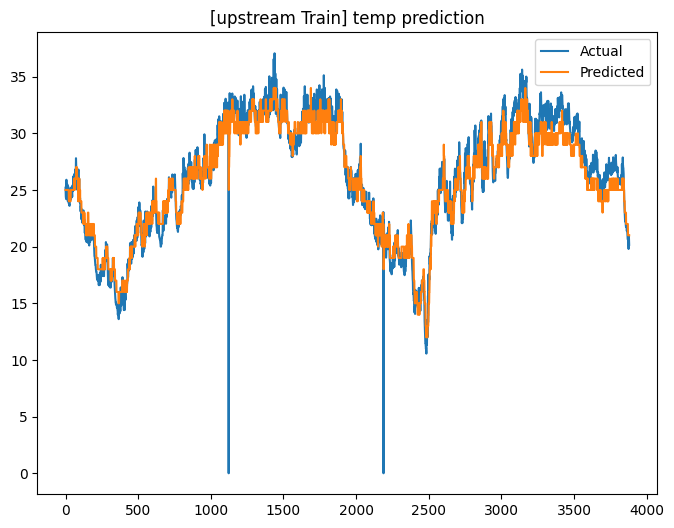

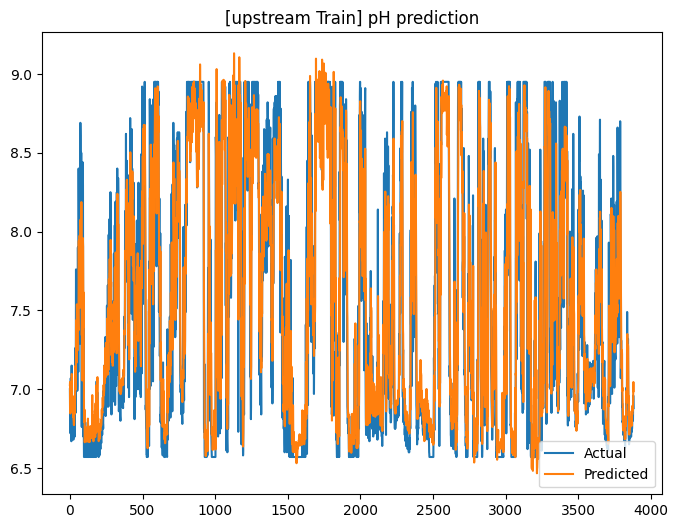

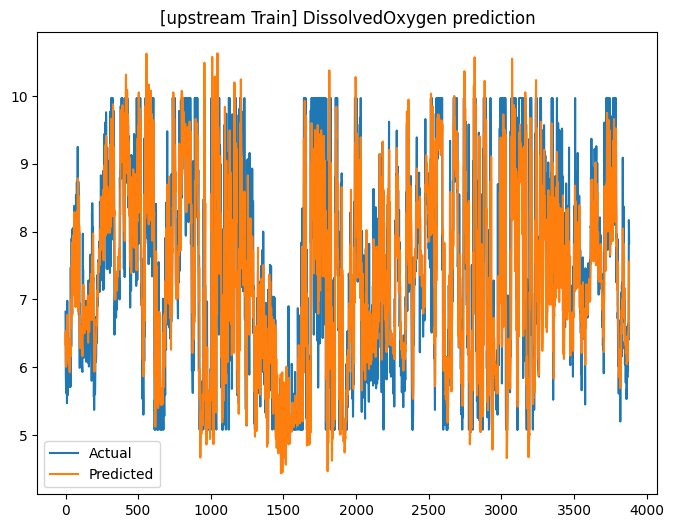

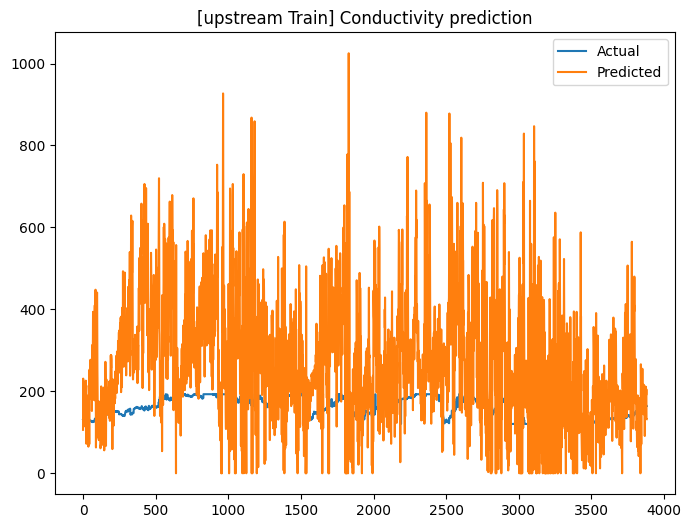

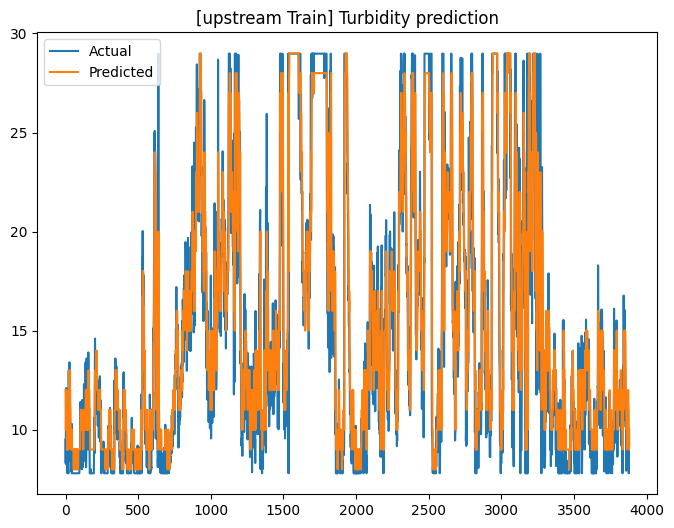

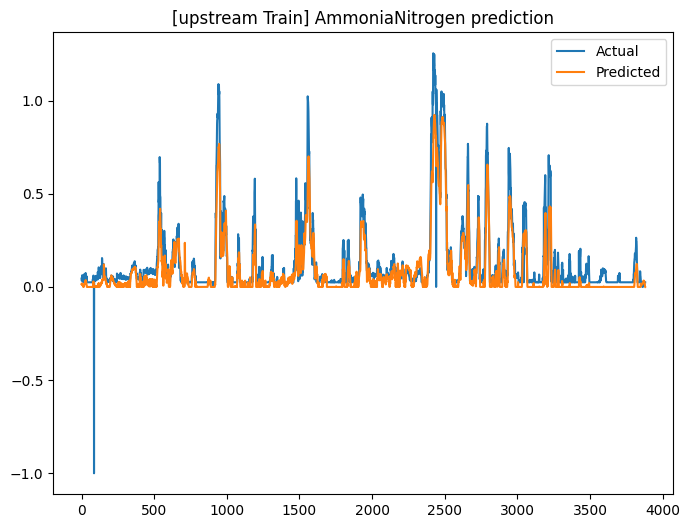

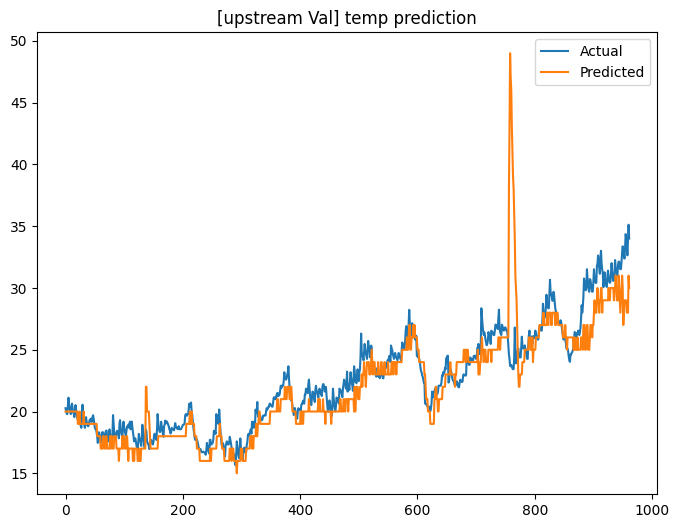

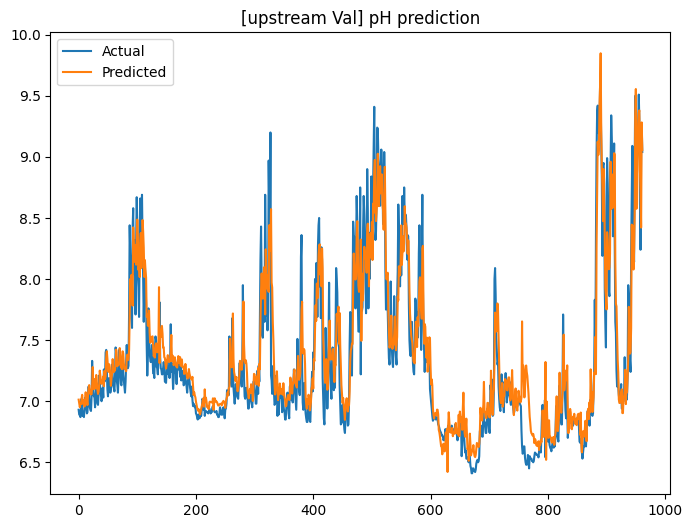

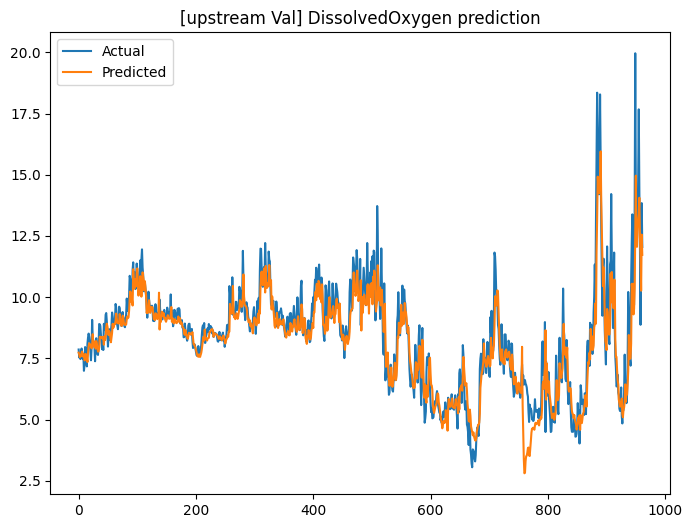

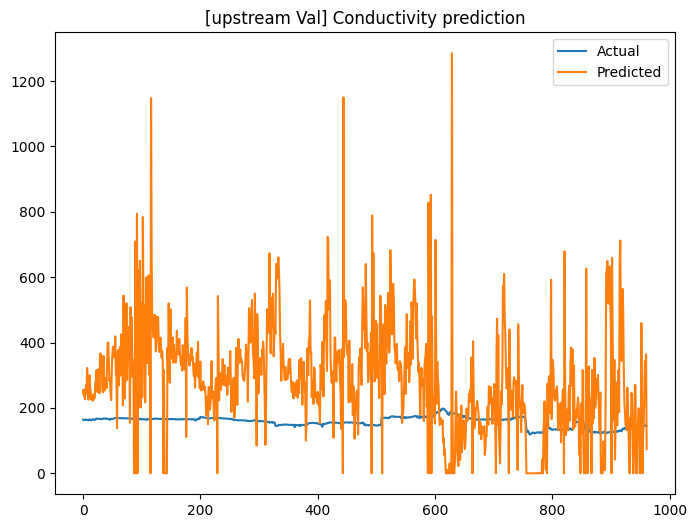

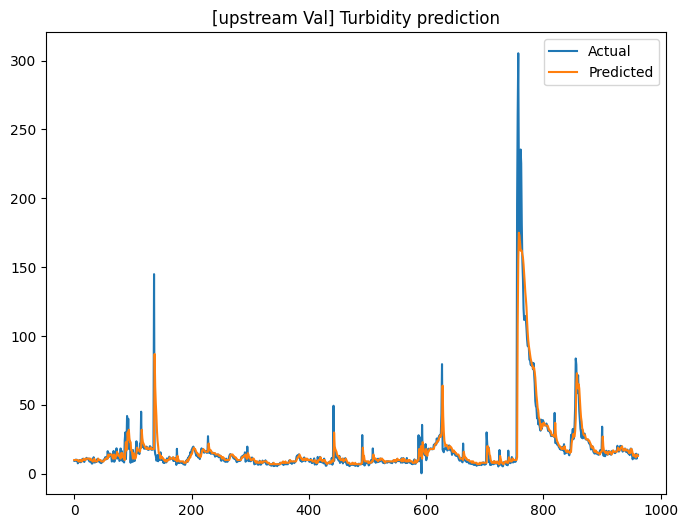

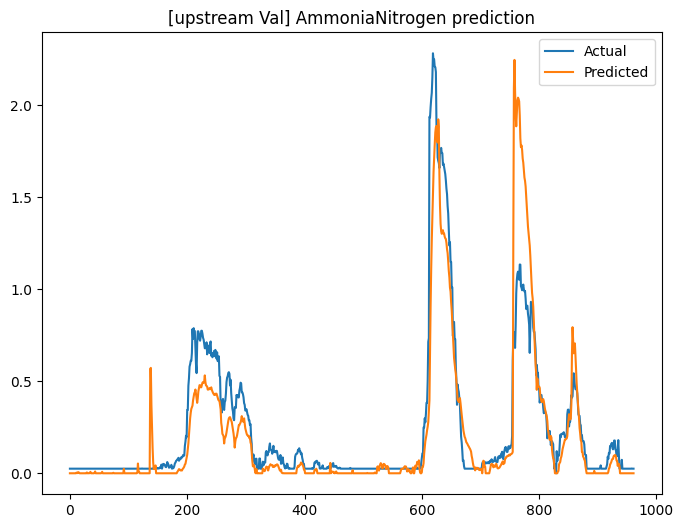

INFO logger 2024-06-03 11:06:19,904 | helpers.py:60 | Metrics for dimension: 0
	mse: 1.0228934288024902, rmse: 1.0113819401207884, mae: 0.7868632674217224, r^2: 0.9619508424982895, nrmse: 0.03856518009788277
INFO logger 2024-06-03 11:06:19,906 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.06992091238498688, rmse: 0.2644256273226687, mae: 0.1886322796344757, r^2: 0.7170192708927143, nrmse: 0.035974796604292834
INFO logger 2024-06-03 11:06:19,907 | helpers.py:60 | Metrics for dimension: 2
	mse: 0.9072475433349609, rmse: 0.9524954295611927, mae: 0.6886376142501831, r^2: 0.7701238390085969, nrmse: 0.1237530968880765
INFO logger 2024-06-03 11:06:19,909 | helpers.py:60 | Metrics for dimension: 3
	mse: 35108.1796875, rmse: 187.37176865125653, mae: 151.7900848388672, r^2: -42.709173025023276, nrmse: 0.9666600145199586
INFO logger 2024-06-03 11:06:19,910 | helpers.py:60 | Metrics for dimension: 4
	mse: 2.4773643016815186, rmse: 1.5739645172879593, mae: 1.1765261888504028, r^2: 0.8215159734


Final Prediction on midstream (Inference Stage)
[Train]: mse: 5852.10888671875, rmse: 76.49907768541233, mae 25.780019760131836, r2: -6.448942682690593, nrmse: 0.64119250234269
[Val]: mse: 12573.3544921875, rmse: 112.13097026329301, mae 39.40996551513672, r2: -27.272553715706263, nrmse: 0.747314093345809




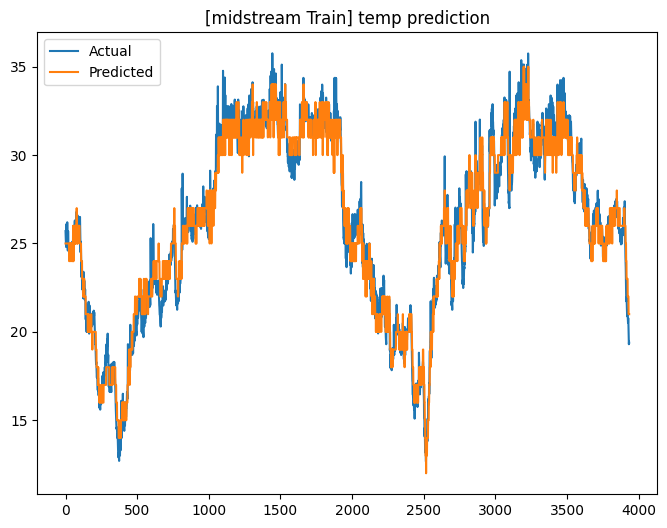

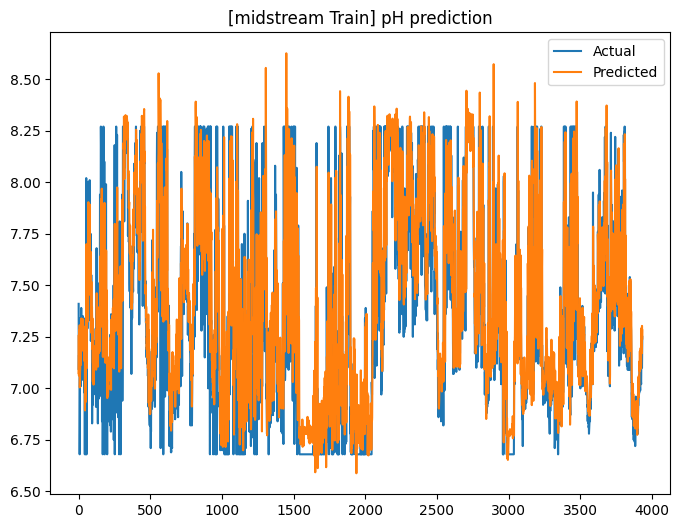

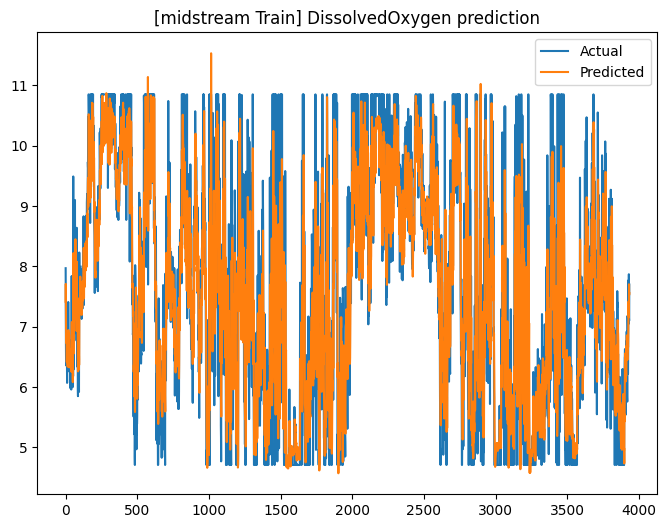

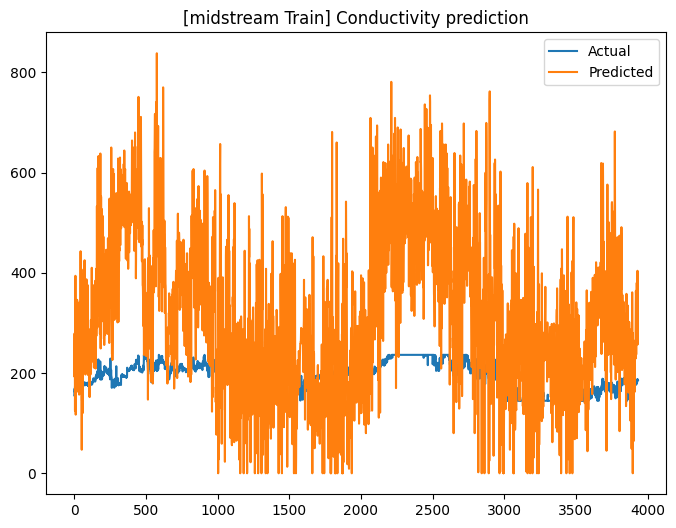

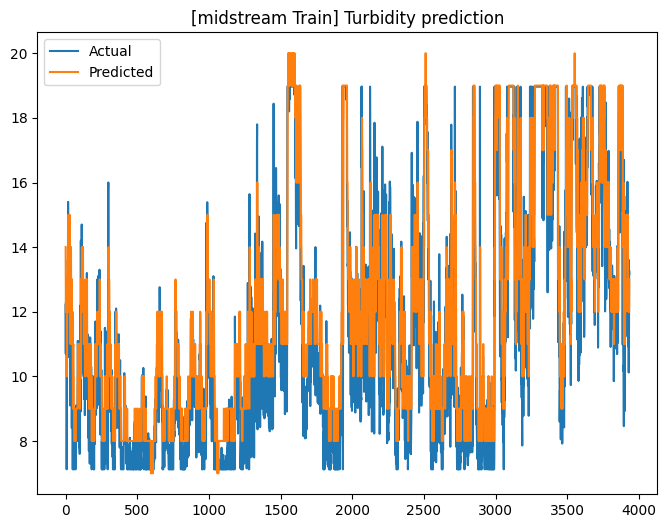

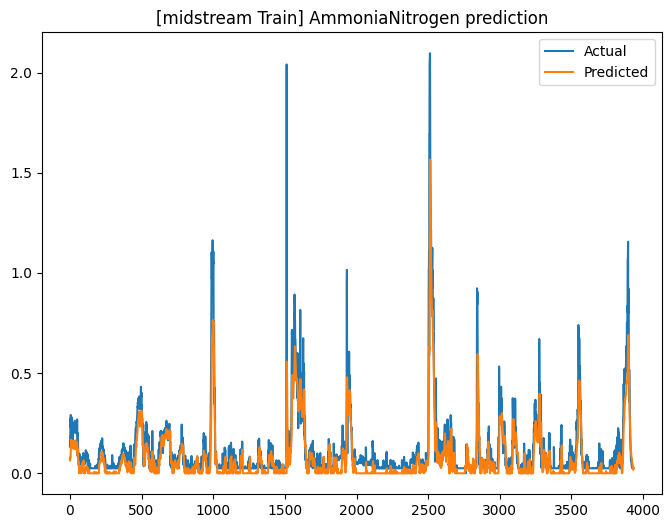

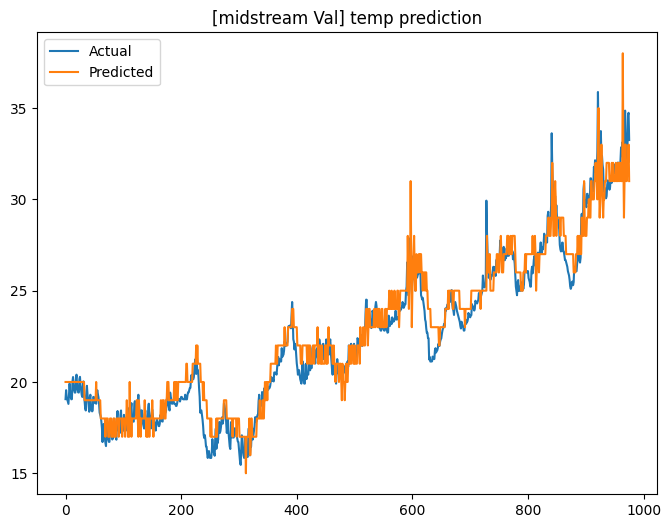

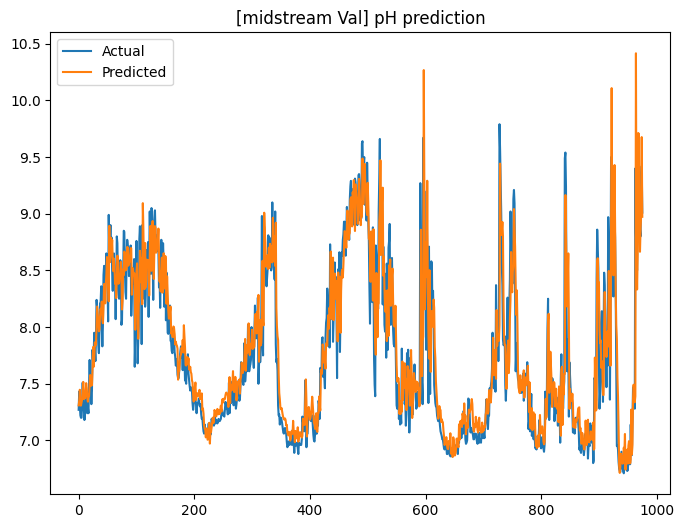

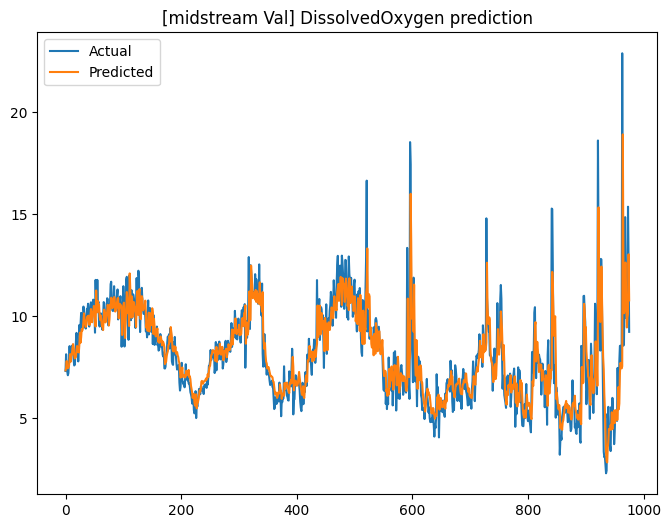

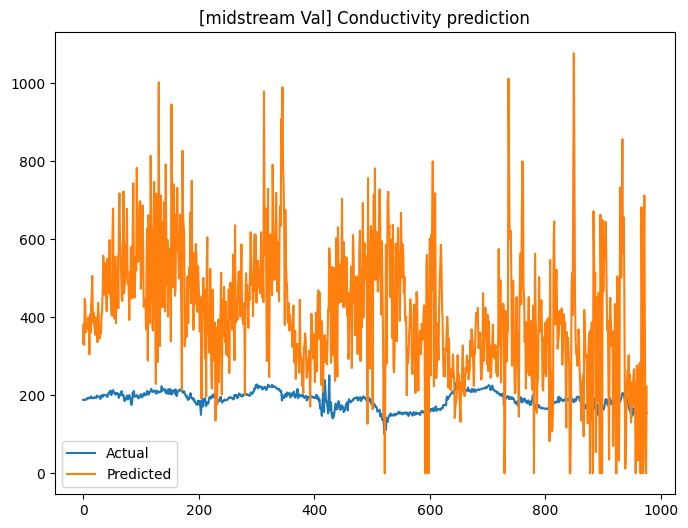

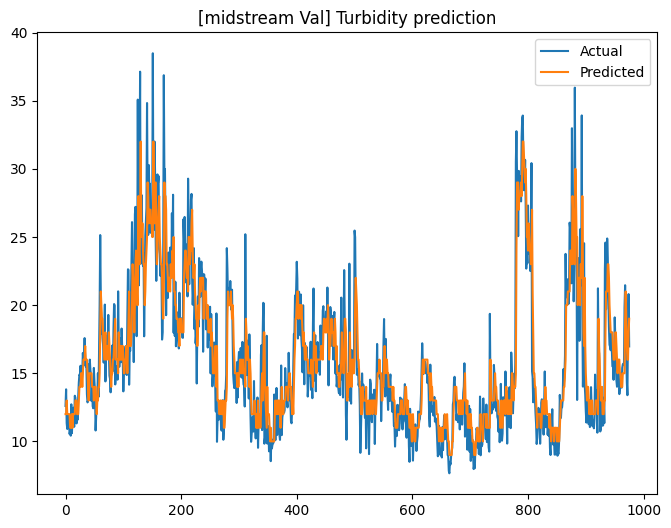

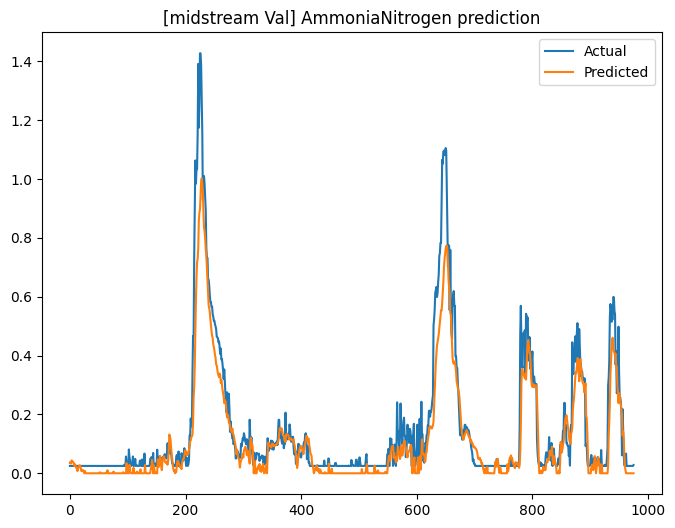

INFO logger 2024-06-03 11:06:21,444 | helpers.py:60 | Metrics for dimension: 0
	mse: 1.426699161529541, rmse: 1.1944451270483467, mae: 0.8424656391143799, r^2: 0.9397222956006218, nrmse: 0.04543095610471806
INFO logger 2024-06-03 11:06:21,446 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.1437334418296814, rmse: 0.37912193530535976, mae: 0.26698988676071167, r^2: 0.5712399285647047, nrmse: 0.05236767250606803
INFO logger 2024-06-03 11:06:21,447 | helpers.py:60 | Metrics for dimension: 2
	mse: 1.4631216526031494, rmse: 1.2095956566568637, mae: 0.8907907605171204, r^2: 0.6233301610095439, nrmse: 0.1768155933150002
INFO logger 2024-06-03 11:06:21,448 | helpers.py:60 | Metrics for dimension: 3
	mse: 5655787.5, rmse: 2378.1899629760446, mae: 1260.1131591796875, r^2: 0.5134162685874035, nrmse: 1.3228562213135093
INFO logger 2024-06-03 11:06:21,450 | helpers.py:60 | Metrics for dimension: 4
	mse: 10.051077842712402, rmse: 3.1703434897046097, mae: 2.149872303009033, r^2: 0.6828554958640616


Final Prediction on downstream (Inference Stage)
[Train]: mse: 942631.6875, rmse: 970.892212091538, mae 210.72560119628906, r2: 0.6630370748865699, nrmse: 0.7460173182866107
[Val]: mse: 61931.125, rmse: 248.85964920010636, mae 54.260929107666016, r2: 0.6920702023102314, nrmse: 0.8453096080606288




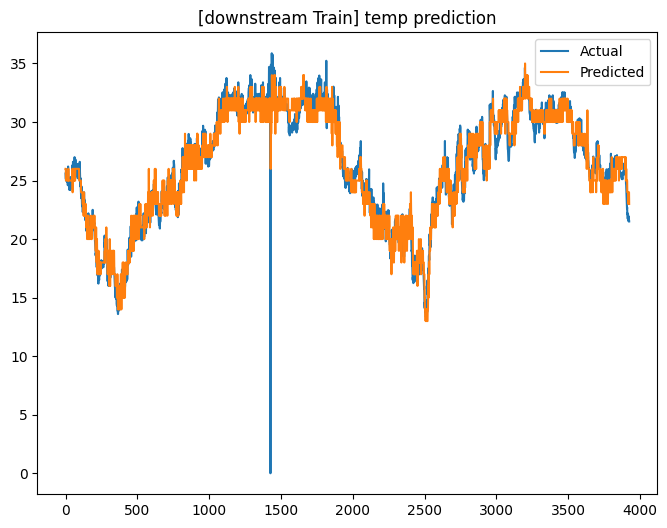

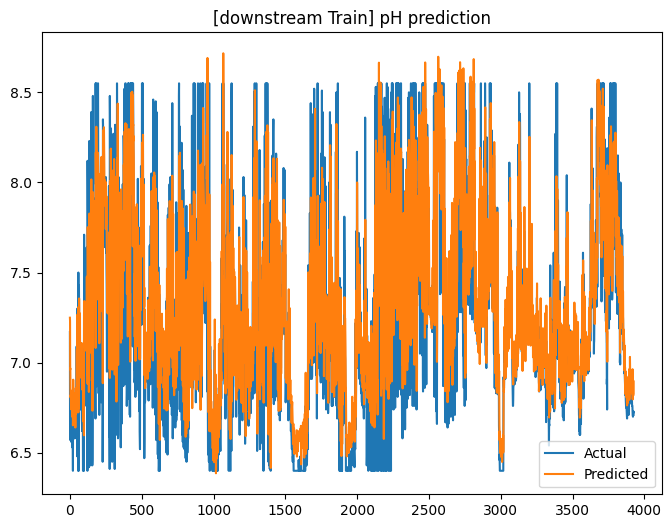

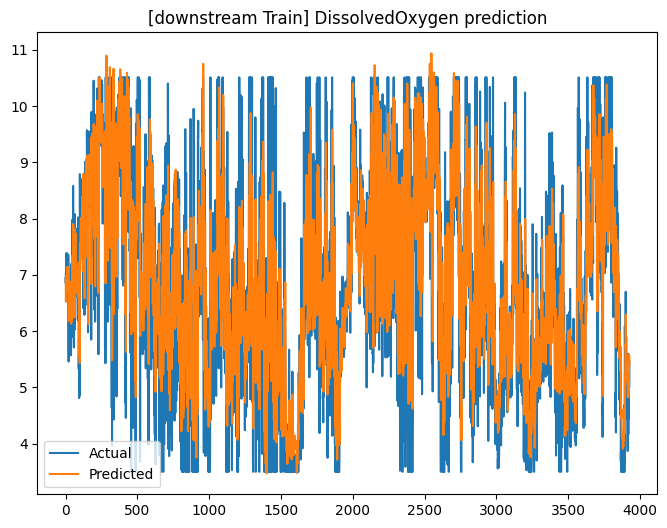

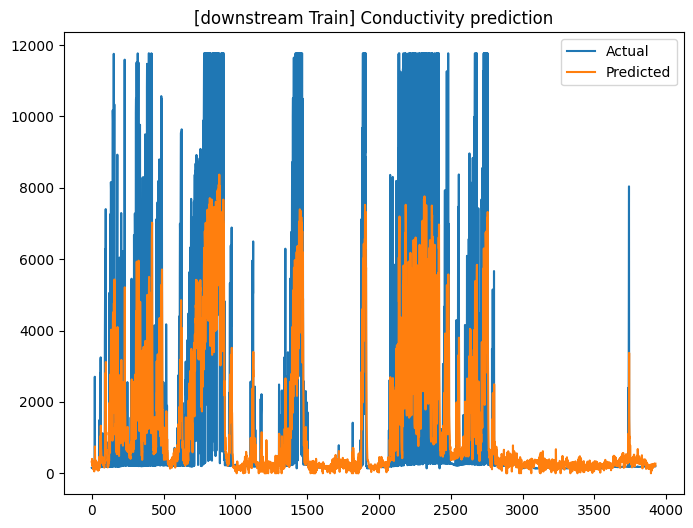

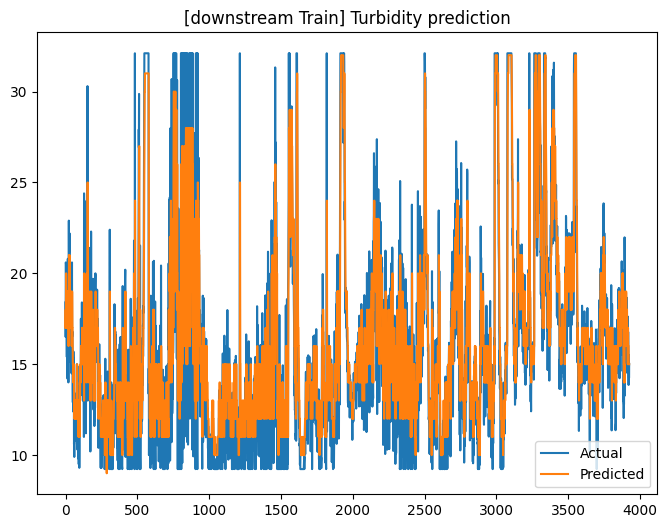

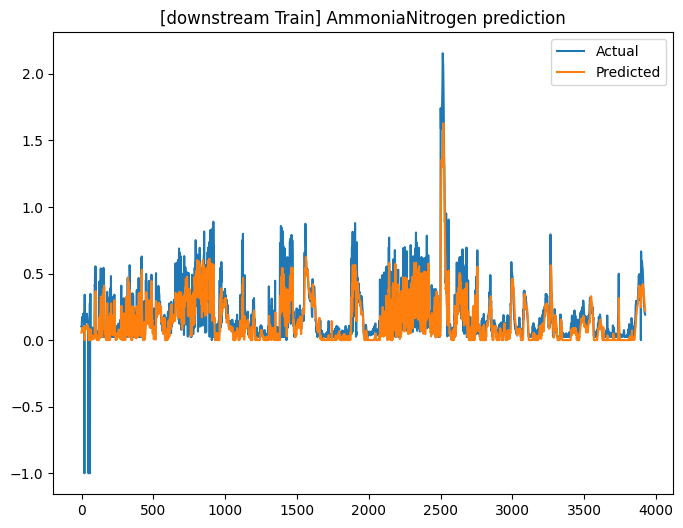

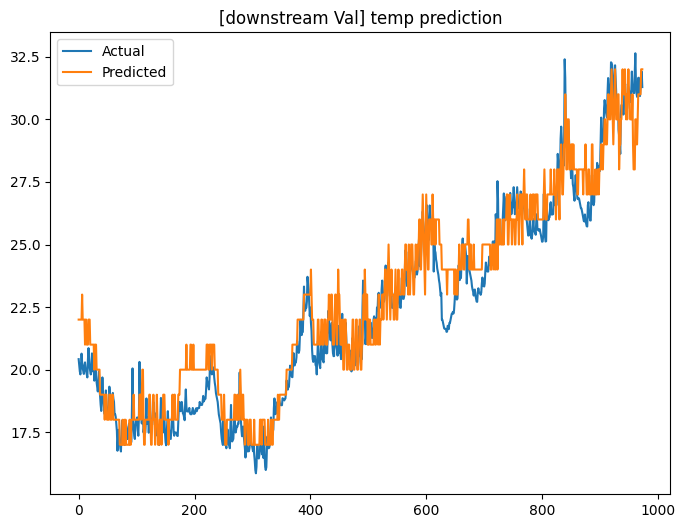

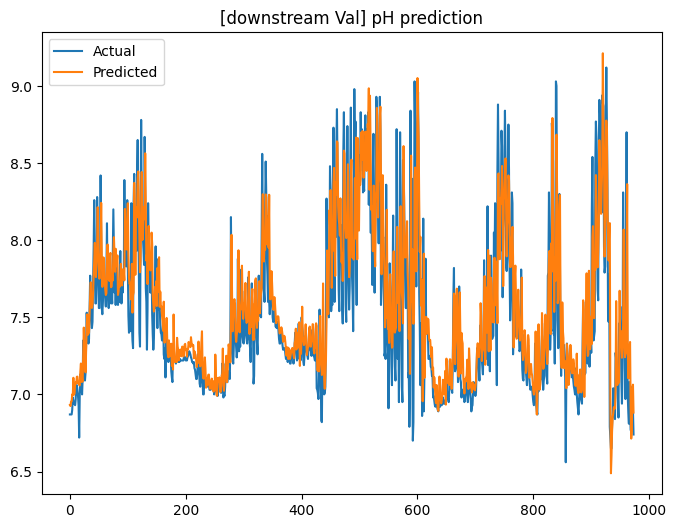

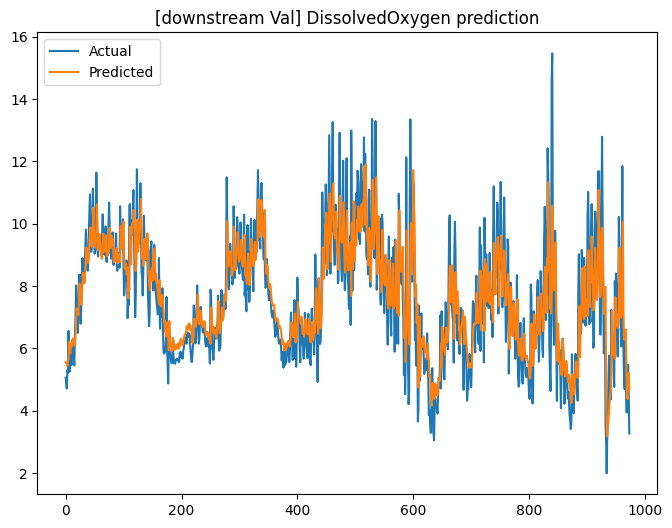

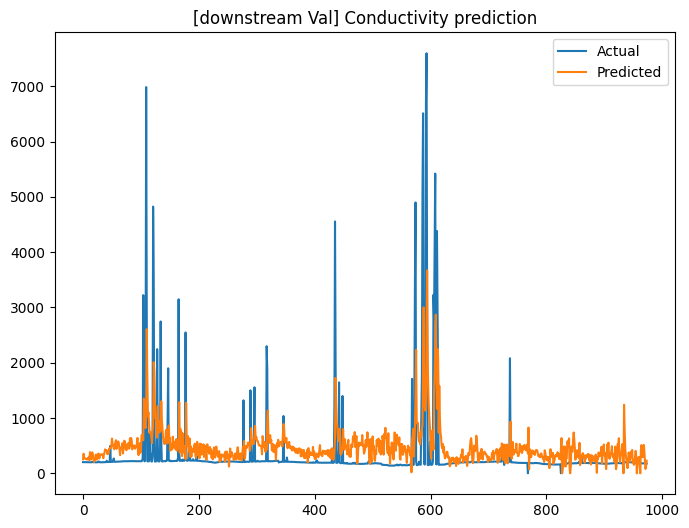

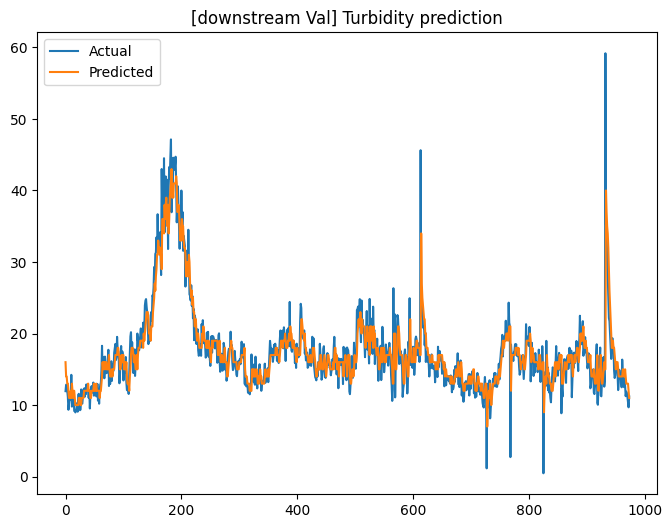

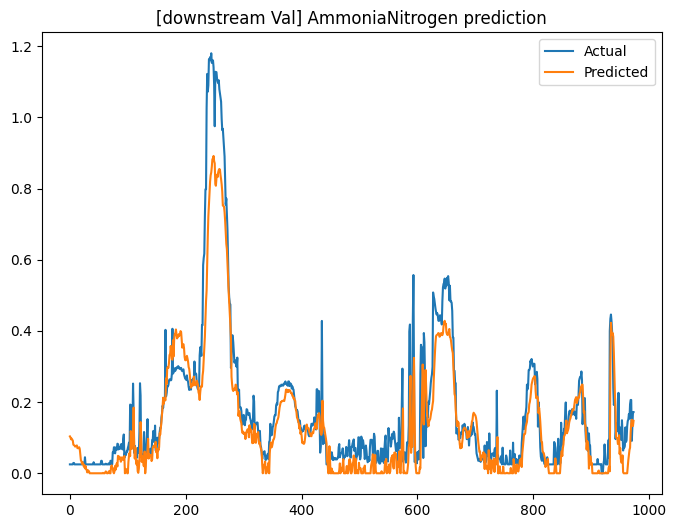

In [86]:
inference(
    global_model,
    client_X_train, 
    client_y_train,
    client_X_val, 
    client_y_val,
    exogenous_data_train, 
    exogenous_data_val,
    y_scaler
)

### Here we test our trained model on previous unseen test data

In [87]:
def transform_preds_test(y_pred_test):
    if not isinstance(y_pred_test, np.ndarray):
        y_pred_test = y_pred_test.cpu().numpy()
    return y_pred_test

def round_predictions_test(y_pred_test, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_test
    for dim in dims:
        y_pred_test[:, dim] = np.rint(y_pred_test[:, dim])
    return y_pred_test

def inverse_transform_test(
    y_test, y_pred_test,
    y_scaler=None, 
    round_preds=False,
    dims=None):
    
    y_pred_test = transform_preds_test(y_pred_test)
    
    if y_scaler is not None:
        y_test = y_scaler.inverse_transform(y_test)
        y_pred_test = y_scaler.inverse_transform(y_pred_test)
    
    # to zeroes
    y_pred_test[y_pred_test < 0.] = 0.
    
    if round_preds:
        y_pred_test = round_predictions_test(y_pred_test, dims)
    
    return y_test, y_pred_test

def predict(
            model,
            cid, 
            X_test,
            y_test,
            exogenous_data_test,
            plot,
            idxs=[0,1,3,7,8,2], # the indices of our targets in X
            apply_round=True,
            round_dimensions=[0, 3, 4]
           ):
    
    if "test" in cid:
        tmp_cid = cid.split("_")
        for s_t in tmp_cid:
            if s_t != "test":
                cid = s_t
                break
    
    num_features = len(X_test[0][0])
    
    test_loader = to_torch_dataset(
        X_test, y_test,
        num_lags=args.num_lags,
        num_features=num_features,
        exogenous_data=exogenous_data_test,
        indices=idxs,
        batch_size=1,
        shuffle=False
    )
    test_mse, test_rmse, test_mae, test_r2, test_nrmse, y_pred_test = test(
                model, test_loader, None, device=device
    )
    
    y_test, y_pred_test = inverse_transform_test(
        y_test, y_pred_test, y_scaler, round_preds=apply_round, dims=round_dimensions
    )
    
    test_mse, test_rmse, test_mae, test_r2, test_nrmse, test_res_per_dim = accumulate_metric(
        y_test, y_pred_test, log_per_output=True, return_all=True
    )
    print(f"Final Prediction in {cid}")
    print(f"[Test]: mse: {test_mse}, rmse: {test_rmse}, mae {test_mae}, "
        f"r2: {test_r2}, nrmse: {test_nrmse}\n\n")
    
    if plot:
        make_plot(y_test, y_pred_test, title="Test", feature_names=args.targets, client=cid)
    

In [88]:
def model_test(
    model, 
    data_paths, 
    x_scaler, 
    y_scaler,
    plot=True,
    idxs=[0,1,3,7,8,2], # the indices of our targets in X
    round_predictions=False,
    round_dimensions=[0, 3, 4],
):
    # In testing we should pre-process and post-process our data and
    # instruct our model to perform predictions
    
    # read the data
    for client in data_paths:
        df = read_data(client)
    
        if args.identifier not in df.columns:
            cid = os.path.splitext(os.path.basename(client))[0]
            df[args.identifier] = cid
        
        test_data = df.copy()
        
        # get X_test, y_test
        X_test, y_test = to_Xy(test_data, targets=args.targets)
        
        # scale features, targets
        X_test = scale_features(X_test, scaler=x_scaler, per_area=False)
        y_test = scale_features(y_test, scaler=y_scaler, per_area=False)
        
        # generate time lags
        X_test = generate_time_lags(X_test, args.num_lags)
        y_test = generate_time_lags(y_test, args.num_lags, is_y=True)
        
        # get datetime features (if specified)
        date_time_df_test = time_to_feature(
            X_test, args.use_time_features, identifier=args.identifier
        )
        
        # get statistics as features (if specified)
        stats_df_test = assign_statistics(X_test, args.assign_stats, args.num_lags,
                          targets=args.targets, identifier=args.identifier)
    
        if date_time_df_test is not None or stats_df_test is not None:
            exogenous_data_test = pd.concat([date_time_df_test, stats_df_test], axis=1)
            exogenous_data_test = exogenous_data_test.loc[:, ~exogenous_data_test.columns.duplicated()].copy()
        else:
            exogenous_data_test = None
        
        # transform to numpy
        if exogenous_data_test is not None:
            exogenous_data_test = get_exogenous_data_by_area(
                exogenous_data_test, identifier=args.identifier
            )
            
            for cid in exogenous_data_test:
                exogenous_data_test[cid] = exogenous_data_test[cid].to_numpy()
        
        # remove identifiers
        X_test, y_test = remove_identifiers(X_test, y_test)
        
        num_features = len(X_test.columns) // args.num_lags
        
        # to timeseries representation
        X_test = to_timeseries_rep(X_test.to_numpy(), args.num_lags, num_features=num_features)
        
        y_test = y_test.to_numpy()
        
        if exogenous_data_test is not None:
            assert len(exogenous_data_test) == 1
            exogenous_data_test = exogenous_data_test[next(iter(exogenous_data_test))]
            
        # make predictions
        predict(model, cid, X_test, y_test, exogenous_data_test, plot, idxs)

In [89]:
test_data_paths = ["../dataset/upstream_test.csv", "../dataset/midstream_test.csv", "../dataset/downstream_test.csv"]

In [90]:
import pandas as pd

test_data_paths = [
    "../dataset/upstream_test.csv",
    "../dataset/midstream_test.csv",
    "../dataset/downstream_test.csv"
]

columns_to_fill = [
    "temp", "pH", "DissolvedOxygen", "Conductivity", "Turbidity",
    "PermanganateIndex", "AmmoniaNitrogen", "TotalPhosphorus", "TotalNitrogen"
]

for path in test_data_paths:
    df = pd.read_csv(path)

    for column in columns_to_fill:
        if column in df.columns:
            df[column].fillna(df[column].mean(), inplace=True)

    df.to_csv(path, index=False)
    # df.to_csv(path.replace(".csv", "_filled.csv"), index=False)

    print(f"NaN值处理完成: {path}")

NaN值处理完成: ../dataset/upstream_test.csv
NaN值处理完成: ../dataset/midstream_test.csv
NaN值处理完成: ../dataset/downstream_test.csv


INFO logger 2024-06-03 11:06:23,865 | helpers.py:60 | Metrics for dimension: 0
	mse: 23.574987411499023, rmse: 4.8554080581861525, mae: 2.048541307449341, r^2: -0.3605399778184024, nrmse: 0.17107771888126838
INFO logger 2024-06-03 11:06:23,866 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.15737369656562805, rmse: 0.39670353737473535, mae: 0.26366186141967773, r^2: 0.827136980641063, nrmse: 0.055619030100313833
INFO logger 2024-06-03 11:06:23,868 | helpers.py:60 | Metrics for dimension: 2
	mse: 1.9932942390441895, rmse: 1.4118407272225113, mae: 0.959203839302063, r^2: 0.7428899841600289, nrmse: 0.17610477224229862
INFO logger 2024-06-03 11:06:23,869 | helpers.py:60 | Metrics for dimension: 3
	mse: 26461.501953125, rmse: 162.66991717316697, mae: 114.60962677001953, r^2: -138.27443263584559, nrmse: 1.5253165678168068
INFO logger 2024-06-03 11:06:23,870 | helpers.py:60 | Metrics for dimension: 4
	mse: 508.125732421875, rmse: 22.541644403678163, mae: 5.464610576629639, r^2: 0.547795957

Final Prediction in upstream
[Test]: mse: 4499.23876953125, rmse: 67.07636520810628, mae 20.573156356811523, r2: -23.785432005110625, nrmse: 1.8894407226372485




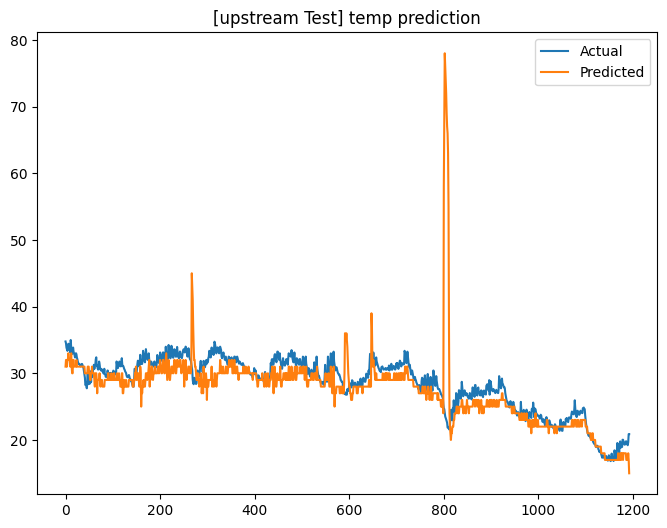

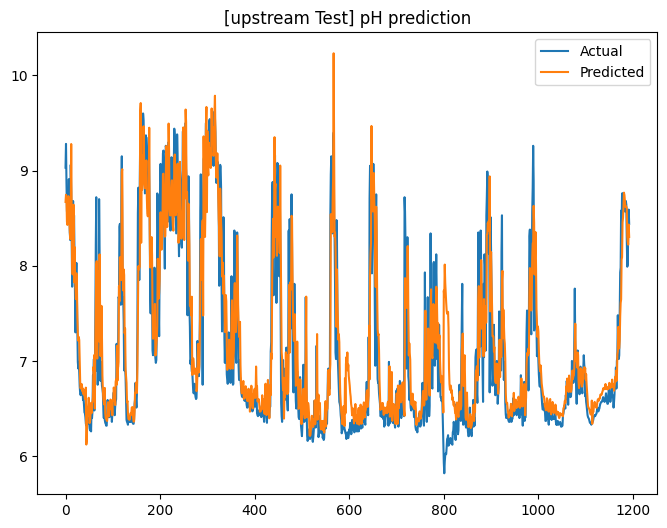

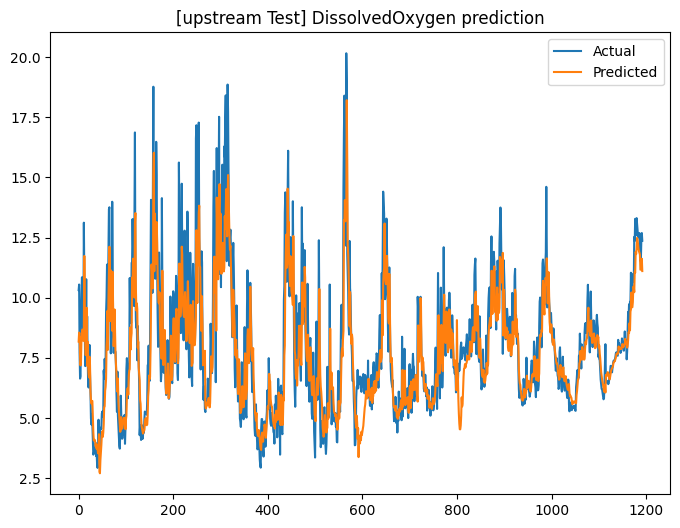

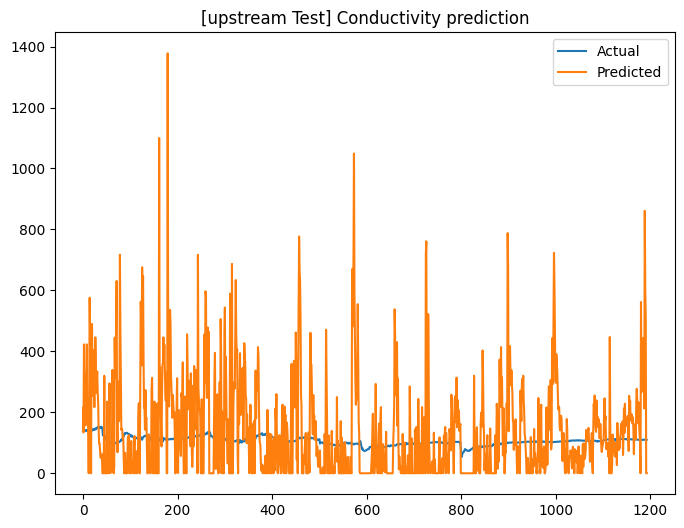

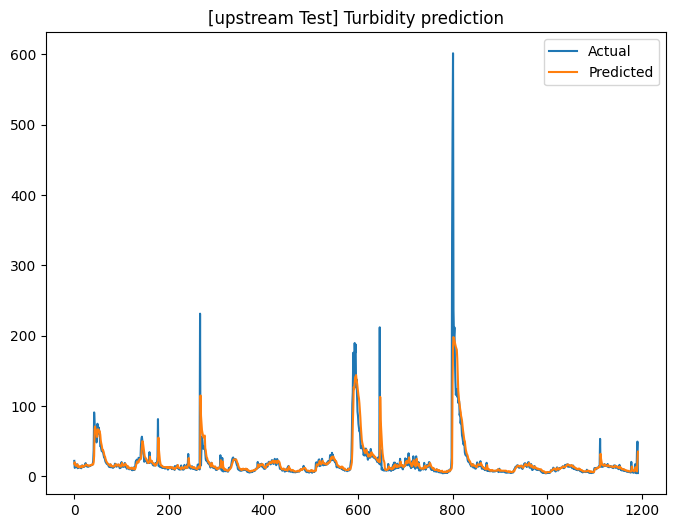

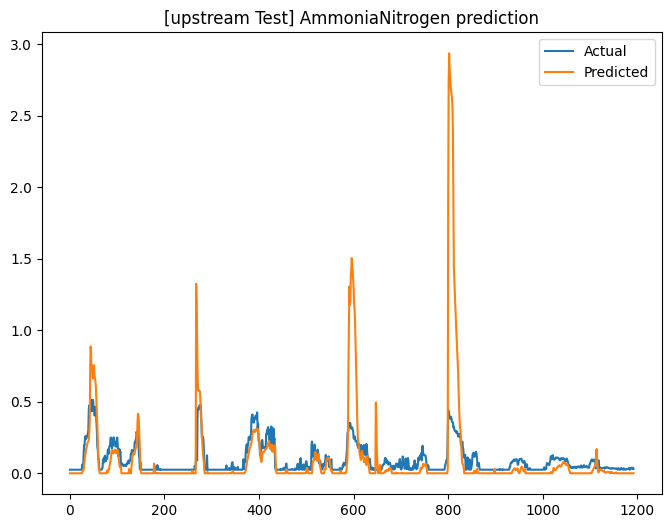

INFO logger 2024-06-03 11:06:25,186 | helpers.py:60 | Metrics for dimension: 0
	mse: 2.7461419105529785, rmse: 1.6571487291589064, mae: 1.156035304069519, r^2: 0.857847271001029, nrmse: 0.05887000875459747
INFO logger 2024-06-03 11:06:25,188 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.08647513389587402, rmse: 0.2940665467132806, mae: 0.19135721027851105, r^2: 0.7023270327440438, nrmse: 0.041533438779944344
INFO logger 2024-06-03 11:06:25,191 | helpers.py:60 | Metrics for dimension: 2
	mse: 2.1877589225769043, rmse: 1.4791074749918967, mae: 0.8514835238456726, r^2: 0.6649846199880338, nrmse: 0.21319588888775753
INFO logger 2024-06-03 11:06:25,193 | helpers.py:60 | Metrics for dimension: 3
	mse: 49102.7734375, rmse: 221.59145614734337, mae: 171.2477569580078, r^2: -110.36089507797257, nrmse: 1.7338204804053339
INFO logger 2024-06-03 11:06:25,194 | helpers.py:60 | Metrics for dimension: 4
	mse: 130.3892364501953, rmse: 11.418810640788966, mae: 6.2039899826049805, r^2: 0.66786005479

Final Prediction in midstream
[Test]: mse: 8206.373046875, rmse: 90.589033811356, mae 29.955764770507812, r2: -18.329857751306566, nrmse: 1.30128211085683




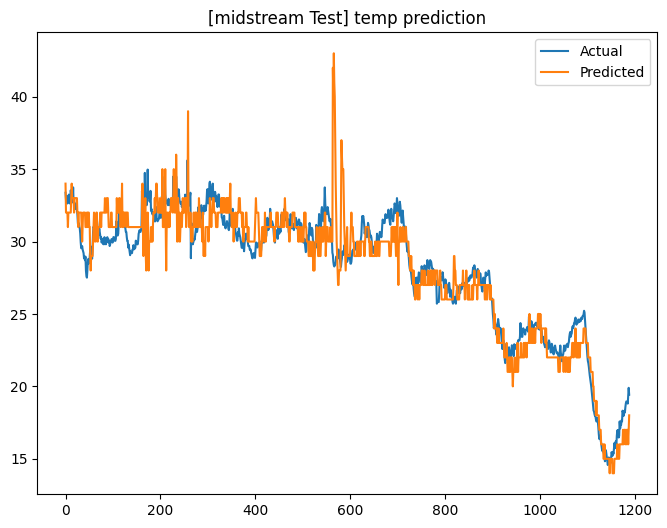

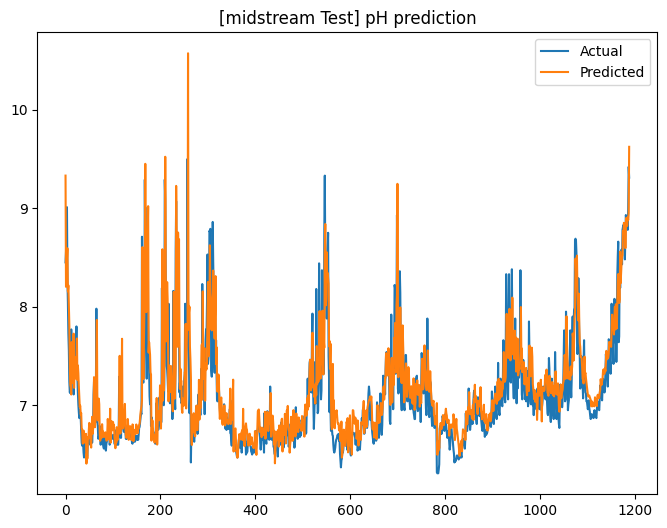

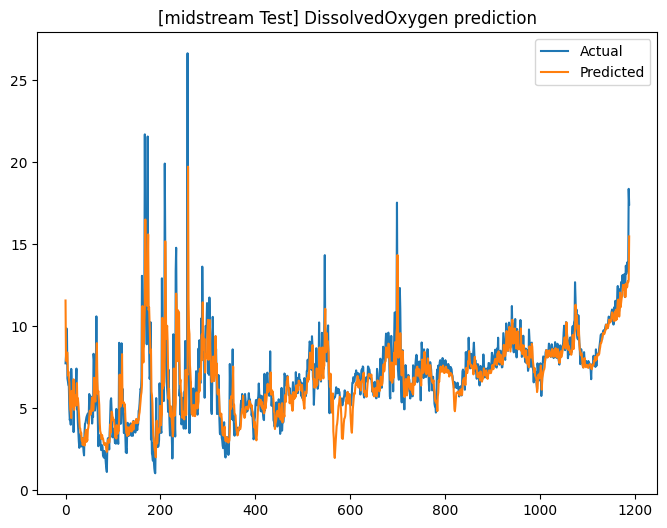

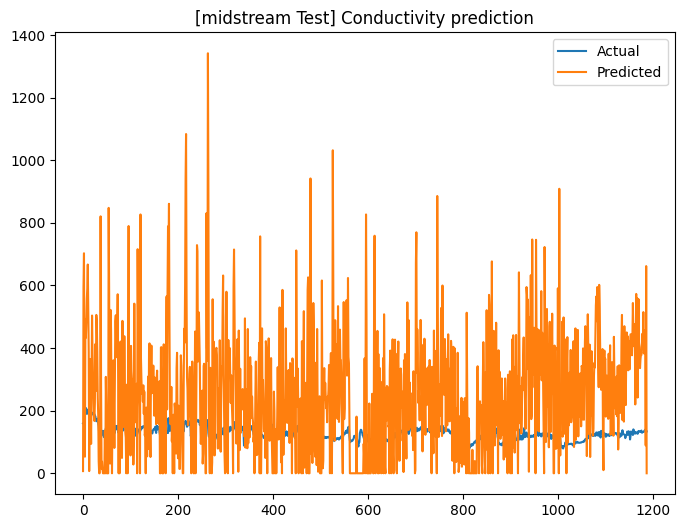

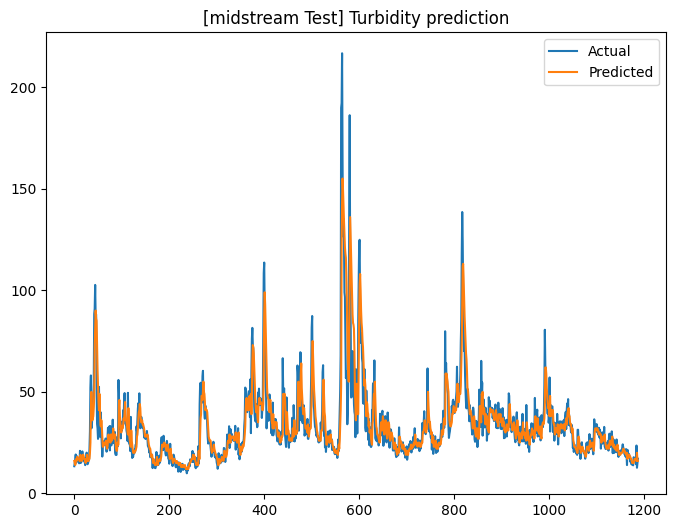

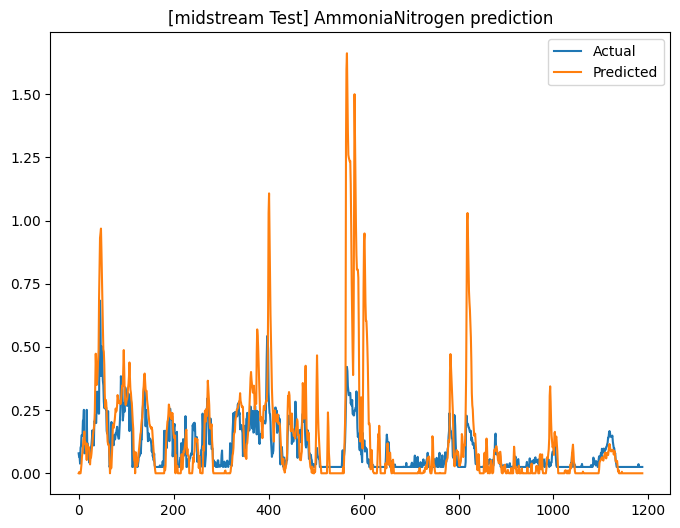

INFO logger 2024-06-03 11:06:26,549 | helpers.py:60 | Metrics for dimension: 0
	mse: 13.280424118041992, rmse: 3.644231622446904, mae: 1.2423083782196045, r^2: 0.19114099777703364, nrmse: 0.129963921940401
INFO logger 2024-06-03 11:06:26,550 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.1088423952460289, rmse: 0.3299127085245867, mae: 0.2204785794019699, r^2: 0.5710576112118922, nrmse: 0.04738153378723734
INFO logger 2024-06-03 11:06:26,552 | helpers.py:60 | Metrics for dimension: 2
	mse: 1.1687036752700806, rmse: 1.081065990247626, mae: 0.7546876668930054, r^2: 0.6951443691235114, nrmse: 0.1626444500275005
INFO logger 2024-06-03 11:06:26,554 | helpers.py:60 | Metrics for dimension: 3
	mse: 26689.810546875, rmse: 163.37016418818646, mae: 119.69400787353516, r^2: -53.6834538488052, nrmse: 1.2135401981467209
INFO logger 2024-06-03 11:06:26,555 | helpers.py:60 | Metrics for dimension: 4
	mse: 357.6018371582031, rmse: 18.910363221212943, mae: 5.994369983673096, r^2: 0.2791006478114467

Final Prediction in downstream
[Test]: mse: 4510.33837890625, rmse: 67.15905284402282, mae 21.332056045532227, r2: -9.740052209443904, nrmse: 1.4588614092384742




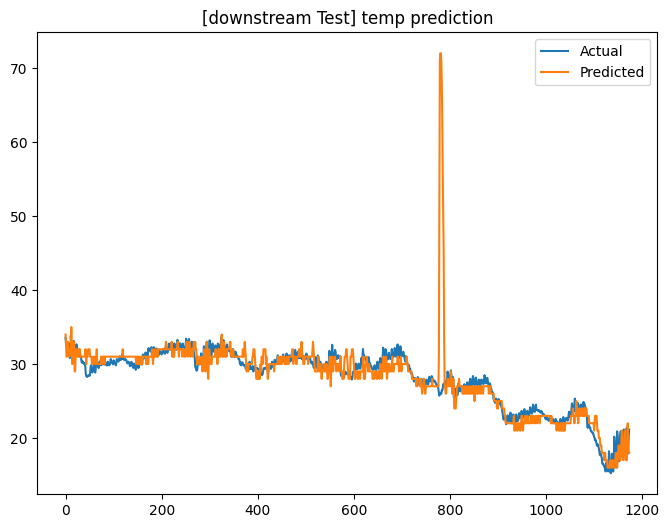

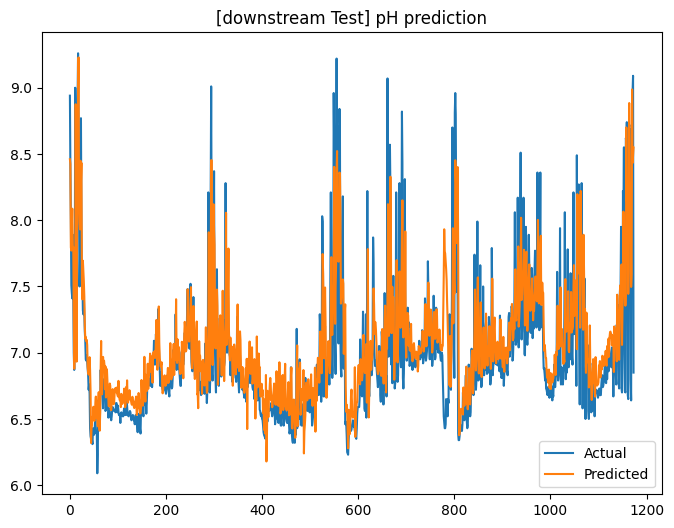

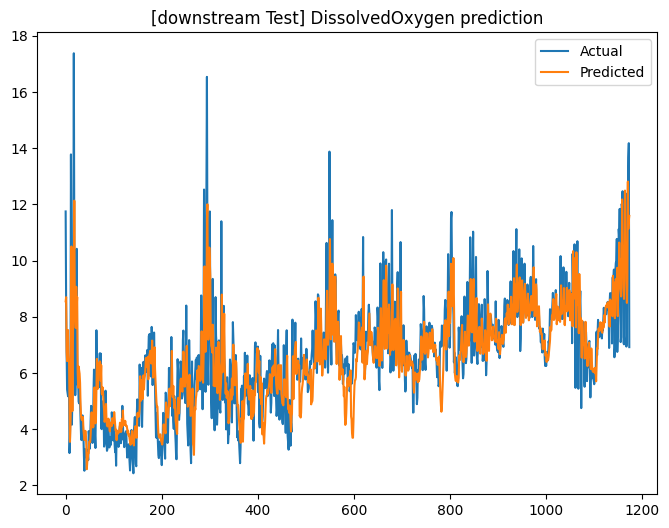

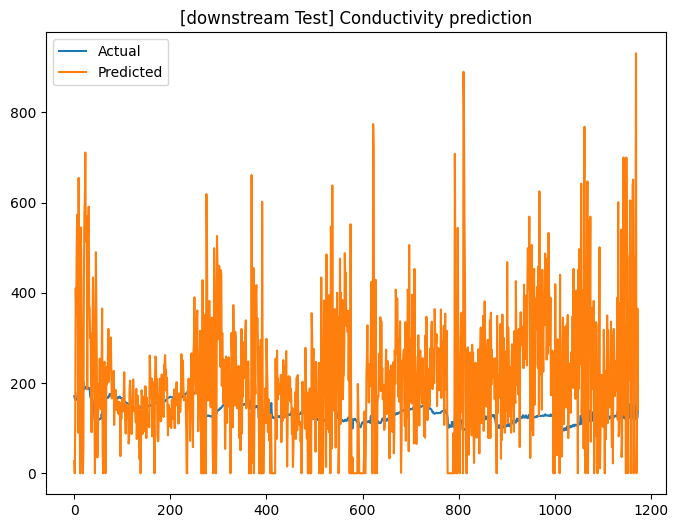

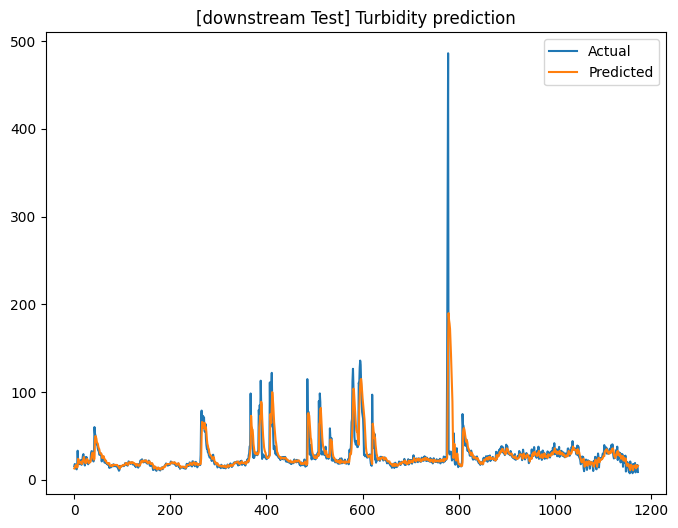

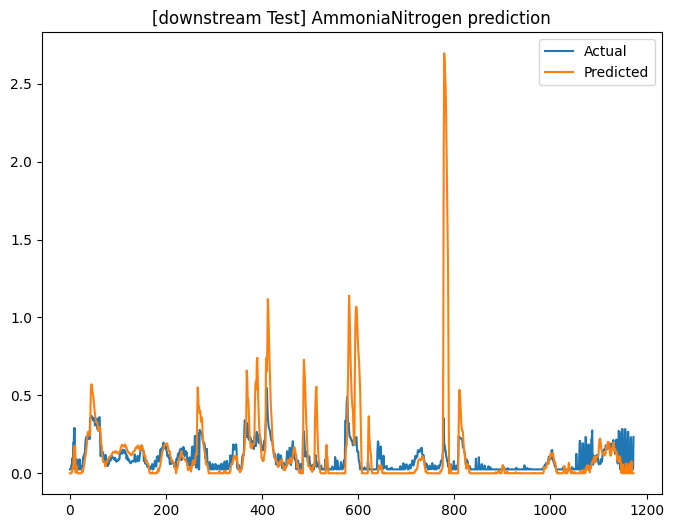

In [91]:
model_test(global_model, 
           test_data_paths, 
           x_scaler, y_scaler,
           round_predictions=True,
          )

In [92]:
x_scaler, y_scaler

(MinMaxScaler(), MinMaxScaler())

In [93]:
def get_minmax_attrs(scaler):
    scaler_attrs = dict()
    scaler_attrs["min_"] = scaler.min_
    scaler_attrs["scale_"] = scaler.scale_
    scaler_attrs["data_min_"] = scaler.data_min_
    scaler_attrs["data_max_"] = scaler.data_max_
    scaler_attrs["data_range_"] = scaler.data_range_
    scaler_attrs["n_features_in_"] = np.array([scaler.n_features_in_])
    scaler_attrs["n_samples_seen_"] = np.array([scaler.n_samples_seen_])
    scaler_attrs["feature_names_in_"] = scaler.feature_names_in_
    
    print(scaler_attrs)
    
    return scaler_attrs

In [94]:
x_scaler_attrs = get_minmax_attrs(x_scaler)
print("\n\n")
y_scaler_attrs = get_minmax_attrs(y_scaler)

{'min_': array([ 0.        , -2.5098042 , -0.47619045, -0.01033705, -0.28509676,
        0.0363901 ,  0.3170577 ,  0.465571  ,  0.0276022 ], dtype=float32), 'scale_': array([2.6983269e-02, 3.9215690e-01, 1.3605441e-01, 8.5863037e-05,
       4.0024813e-02, 3.6390103e-02, 3.1705770e-01, 4.6557099e-01,
       2.7602198e-02], dtype=float32), 'data_min_': array([  0.   ,   6.4  ,   3.5  , 120.39 ,   7.123,  -1.   ,  -1.   ,
        -1.   ,  -1.   ], dtype=float32), 'data_max_': array([3.7060001e+01, 8.9499998e+00, 1.0850000e+01, 1.1766845e+04,
       3.2107502e+01, 2.6480000e+01, 2.1540000e+00, 1.1479000e+00,
       3.5229000e+01], dtype=float32), 'data_range_': array([3.7060001e+01, 2.5499997e+00, 7.3500004e+00, 1.1646455e+04,
       2.4984501e+01, 2.7480000e+01, 3.1540000e+00, 2.1479001e+00,
       3.6229000e+01], dtype=float32), 'n_features_in_': array([9]), 'n_samples_seen_': array([11771]), 'feature_names_in_': array(['temp', 'pH', 'DissolvedOxygen', 'Conductivity', 'Turbidity',
      

#### Store to hdf5 format

In [95]:
import h5py

In [96]:
class ModelSerializer:
    def __init__(self, 
                 model_state, 
                 x_scaler_state,
                 y_scaler_state,
                 save_path: str):
        self.model_state = model_state
        self.save_path = save_path
        self.x_scaler = x_scaler_state
        self.y_scaler = y_scaler_state

    def save(self):
        np_weights = self.state_to_numpy(self.model_state)
        with h5py.File(self.save_path, "w") as f:
            group = f.create_group("model_weights", track_order=True)
            for k, v in np_weights.items():
                group[k] = v
            group = f.create_group("x_scaler", track_order=True)
            for k, v in self.x_scaler.items():
                group[k] = v
            group=f.create_group("y_scaler", track_order=True)
            for k, v in self.y_scaler.items():
                group[k] = v
            

    @staticmethod
    def state_to_numpy(model_state):
        assert type(model_state) in (dict, OrderedDict), \
            f"Model state must be of type dictionary. Received {type(model_state)}"
        k = next(iter(model_state))
        assert type(model_state[k]) in (torch.tensor, torch.Tensor, np.ndarray), \
            f"Model weights must be of type torch.tensor or numpy.ndarray. Received {type(model_state[k])}"
        if type(model_state[k]) == np.ndarray:
            return model_state
        np_ordered_dict = OrderedDict()
        for k, v in model_state.items():
            np_ordered_dict[k] = v.cpu().numpy().astype(np.float64)
        return np_ordered_dict

In [97]:
serializer = ModelSerializer(global_model.state_dict(), x_scaler_attrs, y_scaler_attrs, save_path="model_checkpoint/water_model.h5")

In [98]:
serializer.save()

#### Load back

In [99]:
class ModelLoader:
    def __init__(self, model_path: str, 
                 to_torch: bool = True):
        self.model_path = model_path
        self.to_torch = to_torch

    def load(self):
        state_dict = OrderedDict()
        x_scaler, y_scaler = OrderedDict(), OrderedDict()
        with h5py.File(self.model_path, "r") as f:
            keys = list(f.keys())
            assert "model_weights" in keys
            assert "x_scaler" in keys
            assert "y_scaler" in keys
            model_weights = f["model_weights"]
            named_params = model_weights.keys()
            for k in named_params:
                state_dict[k] = model_weights[k][:]
                
            x_scaler_state = f["x_scaler"]
            named_params = x_scaler_state.keys()
            for k in named_params:
                print(k)
                x_scaler[k] = x_scaler_state[k][:]
            
            y_scaler_state = f["y_scaler"]
            named_params = y_scaler_state.keys()
            for k in named_params:
                y_scaler[k] = y_scaler_state[k][:]
            
        if self.to_torch:
            state_dict = self.state_to_torch(state_dict)
        return state_dict, x_scaler, y_scaler

    @staticmethod
    def state_to_torch(model_state):
        assert type(model_state) in (dict, OrderedDict), \
            f"Model state must be of type dictionary. Received {type(model_state)}"
        k = next(iter(model_state))
        assert type(model_state[k]) in (torch.tensor, torch.Tensor, np.ndarray), \
            f"Model weights must be of type torch.tensor or numpy.ndarray. Received {type(model_state[k])}"
        if type(model_state[k]) in (torch.tensor, torch.Tensor):
            return model_state
        torch_ordered_dict = OrderedDict()
        for k, v in model_state.items():
            torch_ordered_dict[k] = torch.tensor(v).float()
        return torch_ordered_dict

In [100]:
model_loader = ModelLoader("model_checkpoint/water_model.h5")
state_dict, x_scaler, y_scaler = model_loader.load()

min_
scale_
data_min_
data_max_
data_range_
n_features_in_
n_samples_seen_
feature_names_in_


In [101]:
state_dict[next(iter(state_dict))]

tensor([[ 0.0021,  0.0414, -0.1173,  ...,  0.1879,  0.2715, -0.0067],
        [ 0.0038, -0.0433, -0.0298,  ..., -0.0536,  0.0926,  0.0875],
        [-0.0718, -0.0487,  0.0124,  ..., -0.0831,  0.0707,  0.0891],
        ...,
        [-0.1020, -0.1133, -0.1073,  ..., -0.0045, -0.1768,  0.0029],
        [ 0.1254,  0.0331, -0.0137,  ..., -0.0709, -0.0939, -0.0511],
        [-0.1068,  0.0192, -0.1021,  ...,  0.0947, -0.0100,  0.0721]])

In [102]:
x_scaler

OrderedDict([('min_',
              array([ 0.        , -2.5098042 , -0.47619045, -0.01033705, -0.28509676,
                      0.0363901 ,  0.3170577 ,  0.465571  ,  0.0276022 ], dtype=float32)),
             ('scale_',
              array([2.6983269e-02, 3.9215690e-01, 1.3605441e-01, 8.5863037e-05,
                     4.0024813e-02, 3.6390103e-02, 3.1705770e-01, 4.6557099e-01,
                     2.7602198e-02], dtype=float32)),
             ('data_min_',
              array([  0.   ,   6.4  ,   3.5  , 120.39 ,   7.123,  -1.   ,  -1.   ,
                      -1.   ,  -1.   ], dtype=float32)),
             ('data_max_',
              array([3.7060001e+01, 8.9499998e+00, 1.0850000e+01, 1.1766845e+04,
                     3.2107502e+01, 2.6480000e+01, 2.1540000e+00, 1.1479000e+00,
                     3.5229000e+01], dtype=float32)),
             ('data_range_',
              array([3.7060001e+01, 2.5499997e+00, 7.3500004e+00, 1.1646455e+04,
                     2.4984501e+01, 2.74

In [103]:
y_scaler

OrderedDict([('min_',
              array([ 0.        , -2.5098042 , -0.47619045, -0.01033705, -0.28509676,
                      0.3170577 ], dtype=float32)),
             ('scale_',
              array([2.6983269e-02, 3.9215690e-01, 1.3605441e-01, 8.5863037e-05,
                     4.0024813e-02, 3.1705770e-01], dtype=float32)),
             ('data_min_',
              array([  0.   ,   6.4  ,   3.5  , 120.39 ,   7.123,  -1.   ],
                    dtype=float32)),
             ('data_max_',
              array([3.7060001e+01, 8.9499998e+00, 1.0850000e+01, 1.1766845e+04,
                     3.2107502e+01, 2.1540000e+00], dtype=float32)),
             ('data_range_',
              array([3.7060001e+01, 2.5499997e+00, 7.3500004e+00, 1.1646455e+04,
                     2.4984501e+01, 3.1540000e+00], dtype=float32)),
             ('n_features_in_', array([6])),
             ('n_samples_seen_', array([11771])),
             ('feature_names_in_',
              array([b'temp', b'pH', b'D

In [104]:
from sklearn.preprocessing import MinMaxScaler

In [105]:
def set_minmax_attrs(scaler, scaler_attrs):
    scaler.min_ = scaler_attrs["min_"]
    scaler.scale_ = scaler_attrs["scale_"]
    scaler.data_min_ = scaler_attrs["data_min_"]
    scaler.data_max_ = scaler_attrs["data_max_"]
    scaler.data_range_ = scaler_attrs["data_range_"]
    scaler.n_features_in_ = scaler_attrs["n_features_in_"][0] 
    scaler.n_samples_seen_ = scaler_attrs["n_samples_seen_"][0]
    scaler.feature_names_in_ = scaler_attrs["feature_names_in_"] 
    
    return scaler

In [106]:
tmp_scaler = MinMaxScaler()
tmp_scaler = set_minmax_attrs(tmp_scaler, y_scaler)
# tmp_scaler.inverse_transform(np.array(
#     [[1., 1., 1., 1., 1.],
#     [0.5, 0.5, 0.5, 0.5, 0.5]]
# ))

data_to_inverse_transform = np.array([
    [1., 1., 1., 1., 1., 1.],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
])

inverse_transformed_data = tmp_scaler.inverse_transform(data_to_inverse_transform)

In [107]:
inverse_transformed_data

array([[3.70600025e+01, 8.95000001e+00, 1.08500006e+01, 1.17668450e+04,
        3.21075018e+01, 2.15400006e+00],
       [1.85300012e+01, 7.67500013e+00, 7.17500033e+00, 5.94361749e+03,
        1.96152512e+01, 5.77000028e-01]])